In [19]:
import os
import sys
if os.path.abspath('../src') not in sys.path:
    sys.path.append(os.path.abspath('../src'))
# os.environ["PYTHONPATH"] = '/opt/venv/lib/python3.11/site-packages'

import gc
import logging
import multiprocessing
import pickle
import time
from functools import partial
from pathlib import Path
from typing import Any, Literal

import dgl
import numpy as np
import pandas as pd
import pysmiles
import torch
from dgl.dataloading import GraphDataLoader
from dgl.heterograph import DGLGraph
from easydict import EasyDict
from multiprocess import set_start_method
from rdkit import Chem
from tqdm.auto import tqdm

from data_processing import mol_to_dgl, networkx_to_dgl
from model import GNN

try:
    set_start_method("spawn")
except RuntimeError as e:
    print(e)

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)

context has already been set


In [2]:
args = EasyDict({'pretrained_model': 'tag_1024', 'gpu': 0})

# load model parameters
cache_path = '../saved/' + args.pretrained_model + '/'
print('loading hyperparameters of pretrained model from ' + cache_path + 'hparams.pkl')
with open(cache_path + 'hparams.pkl', 'rb') as f:
    hparams = pickle.load(f)

loading hyperparameters of pretrained model from ../saved/tag_1024/hparams.pkl


In [3]:
PRETRAINED_MODEL = 'tag_1024'

# load model parameters
cache_path = Path('../saved/' + PRETRAINED_MODEL)
print('loading model from path ' + str(cache_path))

hparams = pickle.load(cache_path.joinpath('hparams.pkl').open('rb'))
feature_encoder = pickle.load(cache_path.joinpath('feature_enc.pkl').open('rb'))
embedder = GNN(hparams['gnn'], hparams['layer'], hparams['feature_len'], hparams['dim'])
if torch.cuda.is_available():
    embedder.load_state_dict(torch.load(cache_path.joinpath('model.pt'), map_location=torch.device('cpu'), weights_only=True))
    embedder = embedder.to('cuda:' + str(args.gpu))
else:
    embedder.load_state_dict(torch.load(cache_path.joinpath('model.pt'), map_location=torch.device('cpu'), weights_only=True))

loading model from path ../saved/tag_1024


In [4]:
def smiles_to_nx(example: dict[str, Any]) -> dict[str, Any]:
    example['raw_graph'] = pysmiles.read_smiles(example['smiles'], zero_order_bonds=False)
    return example

def smiles_to_dgl(smiles: str, feature_encoder: dict[str, Any]) -> DGLGraph:
    raw_graph = pysmiles.read_smiles(smiles, zero_order_bonds=False)
    graph = networkx_to_dgl(raw_graph, feature_encoder)
    return graph

def smiles_to_dgl_gpu(smiles: str, feature_encoder: dict[str, Any], device: torch.device) -> DGLGraph:
    raw_graph = pysmiles.read_smiles(smiles, zero_order_bonds=False)
    graph = networkx_to_dgl(raw_graph, feature_encoder)
    return graph.to(device)

def smiles_to_dgl_rdkit(smiles: str, feature_encoder: dict[str, Any]) -> DGLGraph:
    mol = Chem.RemoveHs(Chem.MolFromSmiles(smiles))
    graph = mol_to_dgl(mol, feature_encoder)
    return graph

In [5]:
class SmilesEmbedder:
    def __init__(
        self, 
        feature_encoder: dict[str, Any],
        embedder: torch.nn.Module,
        num_proc: int = 4,
        processing_func: Literal['single', 'batch', 'batch_mp', 'rdkit'] = 'single'):

        self.feature_encoder = feature_encoder
        self.embedder = embedder
        self.embedder.eval()
        self.pool = multiprocessing.Pool(processes=num_proc)
        if processing_func == 'single':
            self.processing_function = self.process_one
        elif processing_func == 'batch':
            self.processing_function = self.process_batch
        elif processing_func == 'batch_mp':
            self.processing_function = self.process_batch_mp
        elif processing_func == 'rdkit':
            self.processing_function = self.process_batch_rdkit

    def process_one(self, example: dict[str, Any], rank: int=0):
        """Transforms SMILES into an embedding"""
        device = next(self.embedder.parameters()).device
        raw_graph = pysmiles.read_smiles(example['smiles'], zero_order_bonds=False)
        graph = networkx_to_dgl(raw_graph, self.feature_encoder)
        graph = graph.to(device)
        with torch.no_grad():
            example['embedding'] = self.embedder(graph)
        return example

    def process_batch_mp(self, batch: dict[str, Any], rank: int=0):
        """Transforms SMILES into an embedding"""
        device = next(self.embedder.parameters()).device
        graphs = self.pool.map(
                partial(
                    self.smiles_to_dgl,
                    feature_encoder=self.feature_encoder),
                batch['smiles'])
        with torch.no_grad():
             batch['embedding'] = self.embedder(dgl.batch(graphs).to(device))
        return batch

    def process_batch(self, batch: dict[str, Any], rank: int=0):
        """Transforms SMILES into an embedding"""
        device = next(self.embedder.parameters()).device
        graphs = [self.smiles_to_dgl(smiles, feature_encoder=self.feature_encoder) for smiles in batch['smiles']]
        graphs_gpu = [graph.to(device) for graph in graphs]
        with torch.no_grad():
             batch['embedding'] = self.embedder(dgl.batch(graphs_gpu))
        return batch

    def process_batch_rdkit(self, batch: dict[str, Any], rank: int=0):
        """Transforms SMILES into an embedding"""
        device = next(self.embedder.parameters()).device
        graphs = [self.smiles_to_dgl_rdkit(smiles, feature_encoder=self.feature_encoder) for smiles in batch['smiles']]
        graphs_gpu = [graph.to(device) for graph in graphs]
        with torch.no_grad():
             batch['embedding'] = self.embedder(dgl.batch(graphs_gpu))
        return batch

    @staticmethod
    def smiles_to_dgl(smiles: str, feature_encoder: dict[str, Any]) -> DGLGraph:
        raw_graph = pysmiles.read_smiles(smiles, zero_order_bonds=False)
        graph = networkx_to_dgl(raw_graph, feature_encoder)
        return graph

    @staticmethod
    def smiles_to_dgl_rdkit(smiles: str, feature_encoder: dict[str, Any]) -> DGLGraph:
        mol = Chem.RemoveHs(Chem.MolFromSmiles(smiles))
        graph = mol_to_dgl(mol, feature_encoder)
        return graph

    def __call__(self, smiles: str, rank: int=0) -> Any:
        return self.processing_function(smiles, rank)

### Data processing speed test for different embedder variants with hf.datasets

In [6]:
from datasets import load_dataset

data_files = {"train": ["../../data/CS2/train.csv"], "test": ["../../data/CS2/test.csv"]}
dataset = load_dataset("csv", data_files=data_files, split="train").select(range(10000))


In [7]:
# embs = dataset.map(SmilesEmbedderGPU(feature_encoder=feature_encoder, embedder=mole))
embs = dataset.map(
    SmilesEmbedder(feature_encoder=feature_encoder, embedder=embedder, processing_func='single'),
    #batched=True,
    batch_size=512,
    with_rank=True,
    )

Parameter 'function'=<__main__.SmilesEmbedder object at 0x7f9463f0f790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 10000/10000 [01:08<00:00, 145.25 examples/s]


In [8]:
embs = dataset.map(
    SmilesEmbedder(feature_encoder=feature_encoder, embedder=embedder, processing_func='batch'),
    batched=True,
    batch_size=512,
    with_rank=True,
    )

Map: 100%|██████████| 10000/10000 [00:30<00:00, 330.75 examples/s]


In [9]:
embs = dataset.map(
    SmilesEmbedder(feature_encoder=feature_encoder, embedder=embedder, processing_func='batch_mp'),
    batched=True,
    batch_size=512,
    with_rank=True,
    )

Map: 100%|██████████| 10000/10000 [00:34<00:00, 290.79 examples/s]


In [10]:
embs = dataset.map(
    SmilesEmbedder(feature_encoder=feature_encoder, embedder=embedder, processing_func='rdkit'),
    batched=True,
    batch_size=512,
    with_rank=True,
    )

Map: 100%|██████████| 10000/10000 [00:28<00:00, 346.91 examples/s]


In [14]:
print(f"Estimate for 1B dataset: {1000000000 / 346 / 60 / 60 / 24} days")

Estimate for 1B dataset: 33.451081138942406 days


### Using native DGL data class - no better

In [30]:
class SmilesInMemoryDataset(dgl.data.DGLDataset):
    def __init__(self, smiles_csv: str, feature_encoder: dict[str, Any], cache_path: str='./graphs.bin', gpu: int=0):
        self.feature_encoder = feature_encoder
        self.smiles_data = load_dataset("csv", data_files={'train': [smiles_csv]}, split="train").select(range(30000))
        self.cache_path = cache_path
        self.gpu = gpu
        self.graphs = []
        super().__init__(name='Smiles_data')

    def to_gpu(self):
        if torch.cuda.is_available():
            print('moving data to GPU')
            self.graphs = [graph.to('cuda:' + str(self.gpu)) for graph in self.graphs]

    def save(self):
        print('saving data to ' + self.cache_path)
        dgl.save_graphs(self.cache_path, self.graphs)

    def load(self):
        print('loading graphs from ' + self.cache_path)
        # graphs loaded from disk will have a default empty label set: [graphs, labels], so we only take the first item
        self.graphs = dgl.load_graphs(self.cache_path)[0]
        self.to_gpu()

    def process(self):
        print('transforming data from networkx graphs to DGL graphs')
        for data in tqdm(self.smiles_data):
            # transform networkx graphs to dgl graphs
            graph = smiles_to_dgl(data['smiles'], self.feature_encoder)
            self.graphs.append(graph)
        self.to_gpu()

    def has_cache(self):
        return os.path.exists(self.cache_path)

    def __getitem__(self, i):
        return self.graphs[i]

    def __len__(self):
        return len(self.graphs)

In [31]:
try:
    os.remove('./graphs.bin')
except FileNotFoundError:
    pass

dataset = SmilesInMemoryDataset(
    smiles_csv="../../data/CS2/train.csv",
    feature_encoder=feature_encoder)

transforming data from networkx graphs to DGL graphs


  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [04:40<00:00, 107.07it/s]


moving data to GPU
saving data to ./graphs.bin


### Show that data loading is a bottleneck

In [34]:
def time_vs_batch_size(data, model, batch_sizes: list[int] = [1024]) -> pd.DataFrame:
    model.eval()
    mean_times = []
    for batch_size in tqdm(batch_sizes, leave=False, desc="batch"):
        dataloader = GraphDataLoader(data, batch_size=batch_size)
        with torch.no_grad():
            times = []
            torch.cuda.empty_cache()
            gc.collect()
            for graphs_batch in tqdm(dataloader):
                start_time = time.time()
                _ = model(graphs_batch)
                end_time = time.time()
                times.append(end_time - start_time)
            mean_time = np.mean(times)
        mean_times.append(mean_time)
    return pd.DataFrame({'time': mean_times, 'batch_size': batch_sizes})

In [35]:
results = time_vs_batch_size(dataset, embedder, batch_sizes = [128, 256, 512, 1024, 2048, 4096])
results['time_per_mol'] = results.time / results.batch_size


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]72s/it]


<Axes: xlabel='batch_size'>

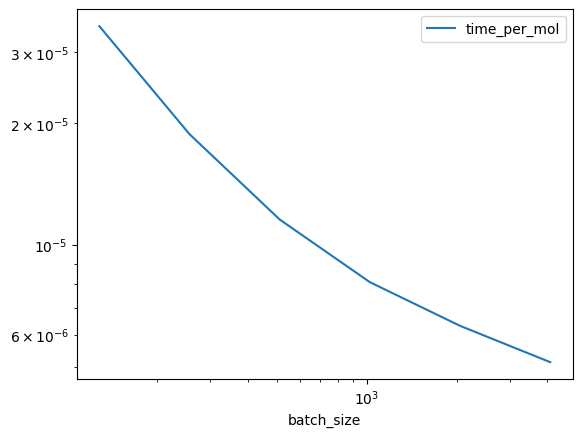

In [36]:
results.plot(x='batch_size', y='time_per_mol', logx=True, logy=True)

In [37]:
print(f"GPU time to embed 1B molecules: {1000000000 * results.time_per_mol.tail(1).item() / 60 / 60} hours")

GPU time to embed 1B molecules: 1.4252812737443794 hours
